In [1]:
import os
import sys
from importlib import reload

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from torch.utils import data as D
# mixed precision
from apex import amp

# Local imports
sys.path.append('../src')
import dataset
import trainer
import models
import utils
import preprocessing
import mix
import transforms

# Transformers
import transformers
from transformers import XLMRobertaModel, XLMRobertaTokenizer, XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

# Prediction analysis
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.special import softmax
from sklearn.calibration import calibration_curve

# Setup device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Seed 
util.seed_everything()

print('use', device)

[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/hpc/home/papkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
use cuda


In [2]:
from transformers import AutoTokenizer 
backbone_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(backbone_name)

In [3]:
batch_size = 8
batch_size_val = 8
num_workers = 8
max_length = 256

valid = dataset.TokenizerDataset('../input/jigsaw_miltilingual_valid_translated.csv', max_length=max_length,
                                 tokenizer=tokenizer, text_column='comment_text')
test = dataset.TokenizerDataset('../input/jigsaw_miltilingual_test_translated.csv', max_length=max_length,
                                tokenizer=tokenizer, text_column='content')

loader_valid = D.DataLoader(valid, 
                            batch_size=batch_size_val, num_workers=num_workers)

loader_test = D.DataLoader(test, 
                           batch_size=batch_size_val, num_workers=num_workers)

len(loader_valid), len(loader_test)

(1000, 7977)

In [4]:
model_list = ['roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned',
              'roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm',
              'roberta_simple_cls_multilingual_translated_1e-3_1e-5_tanh_do=0_from_mlm_uncleaned']

### Average model weights

In [5]:
def average_weights(model_list, root='../checkpoints/'):
    states = [torch.load(f'{root}/{model_name}.pth', map_location='cpu')['model'] for model_name in tqdm(model_list, position=0, desc='load model')]
    output_state = states[0]
    for k in tqdm(output_state.keys(), position=0, desc='copy keys'):
        output_state[k] = torch.stack([s[k] for s in states]).mean(0)
    return output_state

In [6]:
# del model, head, backbone, optimizer

In [7]:
head = models.SimplePoolingHead(in_features=1024, mix=None, dropout=0.0, activation='tanh')
backbone = XLMRobertaModel.from_pretrained(backbone_name, output_hidden_states=False, num_labels=1)
model = models.Model(backbone=backbone, head=head, mix=None, mix_pos='word', features=['cls'])

In [8]:
state = average_weights(model_list)
model.load_state_dict(state)

copy keys: 100%|██████████| 393/393 [00:04<00:00, 92.03it/s] 


<All keys matched successfully>

In [ ]:
trnr = trainer.Trainer('test', model, loader_valid, loader_valid, loader_test)

In [11]:
trnr.model.to(device);

In [12]:
pred_wa, loss, acc, auc = trnr.predict(loader=loader_valid)

predict: 100%|##########| 1000/1000 [02:16<00:00,  7.32it/s]


In [13]:
auc

0.9477328241524661

In [14]:
predictions = []
for name in model_list:
    trnr = trainer.Trainer(name, model, loader_valid, loader_valid, loader_test)
    trnr.load_checkpoint(ignore=['optimizer', 'scheduler'])
    predictions.append(trnr.predict(loader=loader_valid)[0])

Loaded model from ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned.pth
epoch 3, loss: 0.2006 val_loss: 0.2828 val_acc: 0.8602 val_auc: 0.9470 


predict: 100%|##########| 1000/1000 [02:17<00:00,  7.28it/s]


Loaded model from ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm.pth
epoch 1, loss: 0.2018 val_loss: 0.2948 val_acc: 0.8542 val_auc: 0.9465 


predict: 100%|##########| 1000/1000 [02:17<00:00,  7.26it/s]


Loaded model from ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_tanh_do=0_from_mlm_uncleaned.pth
epoch 1, loss: 0.2111 val_loss: 0.2619 val_acc: 0.8724 val_auc: 0.9470 


predict: 100%|##########| 1000/1000 [02:18<00:00,  7.24it/s]


In [15]:
def prediction_analysis(pred, y):
    smpred = softmax(pred / 1, 1)[:,1]
    acc = accuracy_score(y, np.round(smpred))
    auc = roc_auc_score(y, smpred)
    print(f'    acc {acc:.4f}, auc {auc:.4f}\n')

    for lang in ['es', 'it', 'tr']:
        mask = valid.dataset['lang'] == lang
        acc = accuracy_score(y[mask], np.round(smpred[mask]))
        auc = roc_auc_score(y[mask], smpred[mask])
        print(f'{lang}: acc {acc:.4f}, auc {auc:.4f}')
        
    fig, ax = plt.subplots(ncols=2, figsize=(7,3))
    
    ax[0].set_title('Score distribution')
    sns.distplot(smpred[y == 0], ax=ax[0], label='non-toxic')
    sns.distplot(smpred[y == 1], ax=ax[0], label='toxic')
    ax[0].legend()
    
    ax[1].set_title('Calibration plot')
    ax[1].plot(*calibration_curve(y, smpred), 's-')
    plt.show()

    acc 0.8604, auc 0.9471

es: acc 0.8064, auc 0.9340
it: acc 0.7936, auc 0.9131
tr: acc 0.9610, auc 0.9878


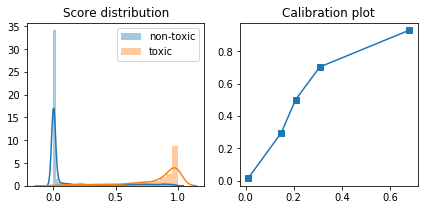

In [16]:
prediction_analysis(predictions[0], valid.y)

    acc 0.8542, auc 0.9465

es: acc 0.7964, auc 0.9313
it: acc 0.7844, auc 0.9114
tr: acc 0.9607, auc 0.9858


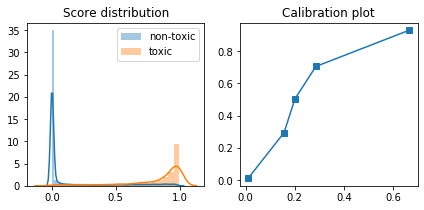

In [17]:
prediction_analysis(predictions[1], valid.y)

    acc 0.8725, auc 0.9471

es: acc 0.8176, auc 0.9298
it: acc 0.8188, auc 0.9163
tr: acc 0.9630, auc 0.9863


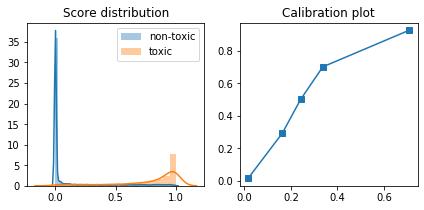

In [18]:
prediction_analysis(predictions[2], valid.y)

    acc 0.8580, auc 0.9477

es: acc 0.8008, auc 0.9330
it: acc 0.7904, auc 0.9152
tr: acc 0.9620, auc 0.9869


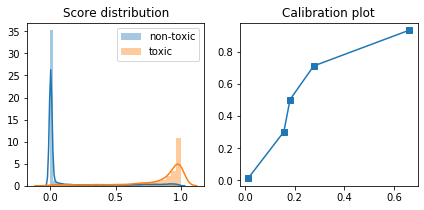

In [19]:
prediction_analysis(pred_wa, valid.y)

    acc 0.8656, auc 0.9482

es: acc 0.8112, auc 0.9330
it: acc 0.8028, auc 0.9155
tr: acc 0.9633, auc 0.9873


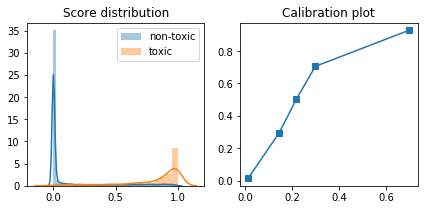

In [26]:
prediction_analysis(np.sum([p * k for p, k in zip(predictions, [0.35,0.3,0.35])], axis=0), valid.y)

In [55]:
from sklearn.metrics import confusion_matrix

In [60]:
confusion_matrix(valid.y, softmax(np.mean(predictions, 0), 1)[:,1] > 0.8)

array([[6398,  372],
       [ 377,  853]])

## Wrong predictions

In [24]:
pd.set_option('display.max_colwidth', -1)
valid.dataset[np.argmax(pred_wa, 1) != valid.y][['comment_text', 'translated', 'toxic']].assign(score=softmax(pred_wa, 1)[np.argmax(pred_wa, 1) != valid.y,1]).head(30)

,comment_text,translated,toxic,score
0,"Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediante su ingestión. Skipe linkin 22px Honor, valor, leltad. 17:48 13 mar 2008 (UTC)","This user does not even make it to the rank of heretic . It should therefore be burned in the barbecue to purify his soul and to our digestive system through ingestion. Skipe linkin 22px Honor, courage, leltad. 17:48 13 mar 2008 (UTC)",0,0.571012
21,"Nihilo sigue empeñado en calificar a García Oliver de líder. Rogaría que nos de una explicación, ya que etiquetar a un anarquista de líder es harto ridículo, si se me permite la expresión... García","Nihilo remains committed to qualify to García Oliver as a leader. Would urge you to give us an explanation, since that labeling an anarchist leader is very ridiculous, if I may be allowed the expression... Garcia",1,0.112298
23,El artículo de víctimas más generales esta hecho un desastre. No pueden fundirse.SanchoPanzaXXI Tu mensaje a la Insula de,"The article of victims, more general, this is a mess. Can't melt.SanchoPanzaXXI Your message to the Insula de",0,0.548228
25,"Coincido. Lo de Feinmann ni siquiera es periodismo, es apenas el ejercicio torpe de un vocero inconsistente de los sectores infames que le abonan el sueldo.","I agree. What of Feinmann's not even journalism, it's just the exercise awkward a spokesman for inconsistent sectors despicable that we pay the salary.",0,0.664710
35,"ti fa così schifo lasciare il doppio spazio?Mpiz (msg) ah, inveve è proprio bello avere tutti i paragrafi appiccicati che non si capisce nemmeno dove inizia uno e finisce l altro..si si proprio belloMpiz (msg) si ma le linee cosi sono tutte appiccicate e non si capisce una beneamata. col doppio spazio rimanendo leggermente piu distanziate, anche a colpo d occhio vedi dove finisce uno ed inizia il successivo.Mpiz (msg)","makes you so disgusting, leave double space?Mpiz (msg) ah, inveve is really nice to have all the paragraphs stuck that you don't know even where start one and ends the other..it is just belloMpiz (msg) is, but the lines so they are all stuck and do not understand a football club. with the double space remaining slightly more spaced out, even at a glance see where finishes one and starts the next.Mpiz (msg)",1,0.379988
40,"Beh, anche io, se per quello, mi considero prima europeo, italiano, sardo e poi cagliaritano (cit.). Ciò nonostante, vivo a Casteddu da sempre! Non per farmi i ca**i tuoi, ma la tua risposta mista alla tua pagina utente (da cui evinco che hai la mia età (31) o più, ma non direi meno) mi ha incuriosito parecchio. A ciò aggiungi il fatto che Cagliari non è, che so, Cremona, dove qualunque persona del nord può veramente bazzicare , magari sbagliando uscita dell A1. Se vieni qua la prima volta, non essendoci nato o non avendoci parenti, è per un motivo preciso (principalmente vacanze, lavoro, rapporti personali/sentimentali), anche se poi conosco tanta gente che non è riuscita a staccarsi per molto tempo (cit.). Ad ogni modo, mi piacerebbe sapere qual è il tuo motivo. Al tempo stesso, sei ovviamente liberissimo di dirmi di farmi i cavoli miei! Ciao, KS «...»","Well, I for one, consider myself european, Italian, sardinian, and then cagliari (cit.). Nevertheless, I live in Casteddu always! Not for me i ca**your, but your mixed response to your user page (from which the competition notice sets out that you are my age (31) or more, but I would not say less) intrigued me a lot. To this add the fact that Cagliari is not, that I know, Cremona, where any person of the north is really pursuing a career , perhaps taking the wrong exit of the A1 motorway. If you come here the first time, not being born or not having relatives, it is for a reason (mainly to vacation, work, personal relationships/emotions), even though I know a lot of people that failed to come off for a long time (cit.). Anyway, I'd like

## Pseudolabeling 

In [58]:
reload(dataset)

<module 'dataset' from '../src/dataset.py'>

In [59]:
valid_pseudo = dataset.PseudolabelMultilingualDataset(
#     fn='../input/jigsaw_miltilingual_valid_translated.csv', 
                                   threshold=0.75,
                                 scores=softmax(np.mean([p[0] for p in predictions], axis=0), 1)[:,1],
                                 max_length=256,
                                 tokenizer=tokenizer, 
#                                  text_column='comment_text',
)

Use 6885 rows for pseudolabels from 8000
Pseudolabeling accuracy:  0.9236020334059549


In [60]:
utils.seed_everything()
loader_valid_pseudo = D.DataLoader(valid_pseudo, batch_size=batch_size, num_workers=num_workers, 
#                                    shuffle=True,
                                   sampler=valid_pseudo.weighted_sampler()
                                  )
len(loader_valid_pseudo)

336

In [61]:
optimizer = AdamW(model.parameters(), lr=1e-6, eps=1e-8, weight_decay=0)

trnr = trainer.Trainer('roberta_simple_cls_multilingual_translated_1e-6_tanh_do=0_pseudo_val', model, 
                       loader_valid_pseudo, loader_valid, loader_test,
                       epochs=5,
                       monitor='val_auc',
                       optimizer=optimizer,
                       gradient_accumulation=16,
                       num_warmup_steps=2,
                      )

In [62]:
trnr.load_checkpoint('../checkpoints/roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm.pth', 
                     ignore=['optimizer', 'scheduler'])

ep. 0003:  47%|####7     | 48/102 [02:14<00:22,  2.40it/s, loss=0.035, acc=0.992, lr=4.76e-7]-6]

Loaded model from ../checkpoints/roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm.pth
epoch 1, loss: 0.2018 val_loss: 0.2948 val_acc: 0.8542 val_auc: 0.9465 


In [ ]:
trnr.fit()

ep. 0003:  47%|####7     | 48/102 [06:59<00:22,  2.40it/s, loss=0.035, acc=0.992, lr=4.76e-7]-6]

Epoch 0 complete. loss=0.1672, val_loss=0.5031, val_acc=0.7985, val_auc=0.9462


ep. 0003:  47%|####7     | 48/102 [07:03<00:22,  2.40it/s, loss=0.035, acc=0.992, lr=4.76e-7]-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-6_tanh_do=0_pseudo_val.pth


ep. 0003:  47%|####7     | 48/102 [11:39<00:22,  2.40it/s, loss=0.035, acc=0.992, lr=4.76e-7]-6]

Epoch 1 complete. loss=0.1513, val_loss=0.4360, val_acc=0.8204, val_auc=0.9465


ep. 0003:  47%|####7     | 48/102 [11:42<00:22,  2.40it/s, loss=0.035, acc=0.992, lr=4.76e-7]-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-6_tanh_do=0_pseudo_val.pth


ep. 0003:  47%|####7     | 48/102 [16:17<00:22,  2.40it/s, loss=0.035, acc=0.992, lr=4.76e-7]-6]

Epoch 2 complete. loss=0.1445, val_loss=0.5126, val_acc=0.8076, val_auc=0.9464


ep. 0003:  47%|####7     | 48/102 [16:21<00:22,  2.40it/s, loss=0.035, acc=0.992, lr=4.76e-7]-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-6_tanh_do=0_pseudo_val_last.pth


ep. 0003:  38%|###8      | 128/336 [00:52<01:26,  2.39it/s, loss=0.142, acc=0.946, lr=3.3e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [65]:
trnr.meters['val_loss'].history

[0.29480347167700527,
 0.5030960928276181,
 0.43603468834236264,
 0.512638290790841,
 0.5280257150679827,
 0.5219983436428011]

### Fine-tuning

In [29]:
valid = dataset.TokenizerDataset('../input/jigsaw_miltilingual_valid_translated.csv', max_length=max_length,
                                 tokenizer=tokenizer, text_column='comment_text', clean=False)

In [28]:
from torch.utils.data import random_split

In [42]:
for i, name in enumerate(model_list):
    torch.manual_seed(i)
    valid_train, valid_test = random_split(valid, [6000, 2000])
    
    loader_valid_train = D.DataLoader(valid_train, batch_size=batch_size, num_workers=num_workers, 
                                      sampler=dataset.weighted_sampler(valid.y[valid_train.indices]))
    loader_valid_test = D.DataLoader(valid_test, batch_size=batch_size, num_workers=num_workers)
    
    optimizer = AdamW(model.parameters(), lr=5e-6, eps=1e-8, weight_decay=0)
    trnr = trainer.Trainer(f'{name}_val{i:02d}', model, loader_valid_train, loader_valid_test, loader_test, optimizer=optimizer, epochs=5, save='best')
    trnr.load_checkpoint(f'../checkpoints/{name}.pth', ignore=['optimizer', 'scheduler'])
    trnr.fit()

ep. 0000:   0%|          | 0/6000 [01:46<?, ?it/s, acc=0, loss=0, lr=5e-6]

Loaded model from ../checkpoints/roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned.pth
epoch 3, loss: 0.2006 val_loss: 0.2828 val_acc: 0.8602 val_auc: 0.9470 


ep. 0000:   0%|          | 0/6000 [04:08<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 0 complete. loss=0.3095, val_loss=0.2378, val_acc=0.8720, val_auc=0.9564


ep. 0000:   0%|          | 0/6000 [04:12<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned_val00.pth


ep. 0000:   0%|          | 0/6000 [06:34<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 1 complete. loss=0.2479, val_loss=0.1944, val_acc=0.9105, val_auc=0.9548


ep. 0000:   0%|          | 0/6000 [06:38<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned_val00_last.pth


ep. 0000:   0%|          | 0/6000 [09:00<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 2 complete. loss=0.2243, val_loss=0.2265, val_acc=0.8900, val_auc=0.9558


ep. 0000:   0%|          | 0/6000 [09:05<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned_val00_last.pth


ep. 0000:   0%|          | 0/6000 [11:27<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 3 complete. loss=0.1916, val_loss=0.2273, val_acc=0.8965, val_auc=0.9578


ep. 0000:   0%|          | 0/6000 [11:32<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned_val00.pth


ep. 0000:   0%|          | 0/6000 [14:15<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 4 complete. loss=0.1655, val_loss=0.2296, val_acc=0.8980, val_auc=0.9570


ep. 0000:   0%|          | 0/6000 [14:20<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned_val00_last.pth


ep. 0000:   0%|          | 0/6000 [14:32<?, ?it/s, acc=0, loss=0, lr=5e-6]

Loaded model from ../checkpoints/roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm.pth
epoch 1, loss: 0.2018 val_loss: 0.2948 val_acc: 0.8542 val_auc: 0.9465 


ep. 0000:   0%|          | 0/6000 [16:55<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 0 complete. loss=0.3024, val_loss=0.2276, val_acc=0.8715, val_auc=0.9521


ep. 0000:   0%|          | 0/6000 [16:58<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm_val01.pth


ep. 0000:   0%|          | 0/6000 [19:21<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 1 complete. loss=0.2337, val_loss=0.2508, val_acc=0.8630, val_auc=0.9556


ep. 0000:   0%|          | 0/6000 [19:23<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm_val01.pth


ep. 0000:   0%|          | 0/6000 [21:58<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 2 complete. loss=0.2051, val_loss=0.1974, val_acc=0.9075, val_auc=0.9553


ep. 0000:   0%|          | 0/6000 [22:02<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm_val01_last.pth


ep. 0000:   0%|          | 0/6000 [24:27<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 3 complete. loss=0.1769, val_loss=0.2442, val_acc=0.8905, val_auc=0.9552


ep. 0000:   0%|          | 0/6000 [24:32<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm_val01_last.pth


ep. 0000:   0%|          | 0/6000 [26:56<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 4 complete. loss=0.1667, val_loss=0.2245, val_acc=0.8970, val_auc=0.9569


ep. 0000:   0%|          | 0/6000 [27:06<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm_val01.pth


ep. 0000:   0%|          | 0/6000 [27:19<?, ?it/s, acc=0, loss=0, lr=5e-6]

Loaded model from ../checkpoints/roberta_simple_cls_multilingual_translated_1e-3_1e-5_tanh_do=0_from_mlm_uncleaned.pth
epoch 1, loss: 0.2111 val_loss: 0.2619 val_acc: 0.8724 val_auc: 0.9470 


ep. 0000:   0%|          | 0/6000 [29:43<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 0 complete. loss=0.2894, val_loss=0.2207, val_acc=0.8930, val_auc=0.9468


ep. 0000:   0%|          | 0/6000 [32:11<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 1 complete. loss=0.2682, val_loss=0.2001, val_acc=0.9080, val_auc=0.9501


ep. 0000:   0%|          | 0/6000 [32:17<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_tanh_do=0_from_mlm_uncleaned_val02.pth


ep. 0000:   0%|          | 0/6000 [34:40<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 2 complete. loss=0.2174, val_loss=0.2198, val_acc=0.8950, val_auc=0.9521


ep. 0000:   0%|          | 0/6000 [34:46<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_tanh_do=0_from_mlm_uncleaned_val02.pth


ep. 0000:   0%|          | 0/6000 [37:09<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 3 complete. loss=0.1778, val_loss=0.2240, val_acc=0.9070, val_auc=0.9520


ep. 0000:   0%|          | 0/6000 [37:15<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_tanh_do=0_from_mlm_uncleaned_val02_last.pth


ep. 0000:   0%|          | 0/6000 [39:38<?, ?it/s, acc=0, loss=0, lr=5e-6]

Epoch 4 complete. loss=0.1726, val_loss=0.2504, val_acc=0.8915, val_auc=0.9521


ep. 0000:   0%|          | 0/6000 [39:43<?, ?it/s, acc=0, loss=0, lr=5e-6]

Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_tanh_do=0_from_mlm_uncleaned_val02_last.pth


In [43]:
test_pred = []
for i, name in enumerate(model_list):
    trnr = trainer.Trainer(f'{name}_val{i:02d}', model, loader_valid_train, loader_valid_test, loader_test)
    trnr.load_checkpoint(ignore=['optimizer', 'scheduler'])
    test_pred.append(trnr.test()[0])

ep. 0000:   0%|          | 0/6000 [39:48<?, ?it/s, acc=0, loss=0, lr=5e-6]

Loaded model from ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=1e-5_tanh_do=0_from_mlm_uncleaned_val00.pth
epoch 3, loss: 0.1916 val_loss: 0.2273 val_acc: 0.8965 val_auc: 0.9578 


ep. 0000:   0%|          | 0/6000 [58:18<?, ?it/s, acc=0, loss=0, lr=5e-6]

Loaded model from ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_from_mlm_val01.pth
epoch 4, loss: 0.1667 val_loss: 0.2245 val_acc: 0.8970 val_auc: 0.9569 


ep. 0000:   0%|          | 0/6000 [1:16:47<?, ?it/s, acc=0, loss=0, lr=5e-6]

Loaded model from ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_tanh_do=0_from_mlm_uncleaned_val02.pth
epoch 2, loss: 0.2174 val_loss: 0.2198 val_acc: 0.8950 val_auc: 0.9521 


test: 100%|##########| 7977/7977 [18:24<00:00,  7.22it/s]


In [45]:
for p, m in zip(test_pred, model_list):
    np.save(f'../output/{m}.npy', p)

In [47]:
averaged = np.mean(test_pred, 0)

In [48]:
submission = pd.read_csv('../input/sample_submission.csv')

In [51]:
submission['toxic'] = softmax(averaged, 1)[:,1]
submission.head()

,id,toxic
0,0,0.000244
1,1,0.000143
2,2,0.582583
3,3,0.000276
4,4,0.000166


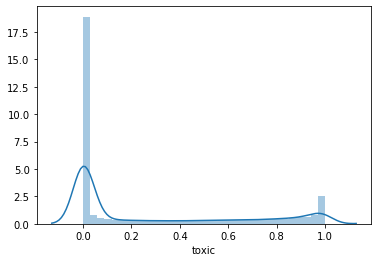

In [52]:
sns.distplot(submission.toxic)

In [53]:
submission.to_csv('../submissions/submission_multilingual_ensemble.csv', index=False)